1. Load datasets, apply some filters, return list of orders, product index mapping
2. Filter out products that appear less than 10 times, rename them to "UNKNOWN", return vocabulary and frequency
3. Re-index rare products in orders
4. Find all (target, contexts) pairs from orders, consider each order is one "sentence"
5. Create a generator to sample products for negative context sampling with weight = frequency**(0.75) (use random.choises)
6. Create a Dataset that returns (target, [contexts + negative_contexts], mask). Note that len(contexts + negative_contexts) must be constant so that we can batch.
7. Define loss function
8. Define pytorch lightning class
9. Train and save model
10. Test with some nearest products using cosine similarity

In [1]:
# Imports and global variables

import numpy as np
import pandas as pd
import random
from typing import List, Dict, Tuple

import pytorch_lightning as pl
import torch.multiprocessing
import torch.nn.functional as F
import tqdm

# 1. Load datasets, apply some filters, return list of orders, product index mapping

In [2]:
def get_product_name_by_id() -> Dict[int, str]:    
    df = pd.read_csv("data/products.csv", usecols=["product_id", "product_name"])
    return df.set_index('product_id').to_dict()['product_name']

product_name_by_id = get_product_name_by_id()
print(f"Number of product: {len(product_name_by_id)}")
print(list(product_name_by_id.items())[:5])

Number of product: 49688
[(1, 'Chocolate Sandwich Cookies'), (2, 'All-Seasons Salt'), (3, 'Robust Golden Unsweetened Oolong Tea'), (4, 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce'), (5, 'Green Chile Anytime Sauce')]


In [3]:
def get_list_orders(testing=True) -> List[List[int]]:
    if testing:
        order_df = pd.read_csv("data/order_products__train.csv")
    else:
        order_prior_df = pd.read_csv("data/order_products__prior.csv")
        order_train_df = pd.read_csv("data/order_products__train.csv")
        order_df = pd.concat([order_prior_df, order_train_df], axis=0)
    order_df = order_df.sort_values(by=["order_id", "add_to_cart_order"])
    return order_df.groupby("order_id")["product_id"].apply(list).tolist()


all_orders = get_list_orders()
print(f"Number of orders: {len(all_orders)}")
print(f"First 3 orders: {all_orders[:3]}")

Number of orders: 131209
First 3 orders: [[49302, 11109, 10246, 49683, 43633, 13176, 47209, 22035], [39612, 19660, 49235, 43086, 46620, 34497, 48679, 46979], [11913, 18159, 4461, 21616, 23622, 32433, 28842, 42625, 39693]]


In [4]:
from collections import Counter
c = Counter([len(order) for order in all_orders])
print(c)

Counter({5: 8895, 6: 8708, 7: 8541, 4: 8218, 3: 8033, 8: 7983, 2: 7368, 9: 7217, 1: 6845, 10: 6553, 11: 6034, 12: 5383, 13: 4843, 14: 4394, 15: 3831, 16: 3522, 17: 3108, 18: 2719, 19: 2473, 20: 2102, 21: 1857, 22: 1681, 23: 1462, 24: 1292, 25: 1079, 26: 986, 27: 860, 28: 679, 29: 634, 30: 553, 31: 446, 32: 403, 33: 346, 34: 315, 35: 280, 36: 210, 37: 193, 38: 178, 39: 142, 40: 99, 41: 90, 42: 88, 44: 79, 43: 75, 45: 64, 47: 49, 46: 48, 48: 32, 50: 31, 49: 26, 51: 24, 52: 23, 53: 18, 54: 15, 55: 12, 56: 10, 60: 8, 57: 6, 58: 5, 63: 5, 70: 4, 64: 4, 59: 4, 65: 3, 61: 3, 62: 3, 72: 2, 76: 2, 66: 2, 68: 2, 74: 2, 80: 2, 75: 1, 77: 1, 67: 1})


In [5]:
# Filter out orders with only one product (165393 of them)
min_product_per_order = 5
orders = [order for order in all_orders if len(order) >= min_product_per_order]
print(f"Number of orders with at least {min_product_per_order}: {len(orders)}")

Number of orders with at least 5: 100745


In [6]:
min_freq = 10
product_freq = Counter([product for order in orders for product in order])
least_common_products = [
    product for product in product_name_by_id if product_freq.get(product, 0) <= min_freq
]
print(len(least_common_products))


36798


In [7]:
# remove
# map uncommon product_id to <unkown>
for product_id in least_common_products:
    product_name_by_id[product_id] = "<UNKNOWN>"
# map product_id to index
unique_product_names = list(set(product_name_by_id.values()))
product_index_by_name = {
    product_name: i for i, product_name in enumerate(unique_product_names)
}
product_index_by_id = {
    product_id: product_index_by_name[product_name_by_id[product_id]]
    for product_id in product_name_by_id
}

In [8]:
# orders as list of product_indices instead of product_ids

orders = [[product_index_by_id[product_id] for product_id in order] for order in orders]

In [9]:
orders[:3]

[[4842, 7445, 8062, 11435, 374, 1357, 12387, 843],
 [1172, 1381, 5451, 9617, 483, 1441, 10641, 6032],
 [4607, 7332, 611, 5116, 8416, 757, 3470, 10124, 4579]]

In [10]:
max(product_index_by_name.values())

12890

# 4. Find all (target, contexts) pairs from orders, consider each order is one "sentence"

In [11]:
%%time
# maximum distance from a positive context product to target product
context_window = 5
# total number of context products, including positive and negative products
num_context_products = 20
all_targets = []
all_positive_contexts = []
for order in tqdm.tqdm(orders):
    for i, product in enumerate(order):
        all_targets.append(product)
        positive_context = [
            order[j]
            for j in range(
                max(0, i - context_window), min(len(order), i + context_window + 1)
            )
            if j != i
        ]
        all_positive_contexts.append(positive_context)

100%|██████████| 100745/100745 [00:02<00:00, 47959.23it/s]

CPU times: user 2.08 s, sys: 27.6 ms, total: 2.11 s
Wall time: 2.1 s


In [12]:
# sanity check
for i in range(5):
    print(f"target {all_targets[i]}, positive_contexts: {all_positive_contexts[i]}")


target 4842, positive_contexts: [7445, 8062, 11435, 374, 1357]
target 7445, positive_contexts: [4842, 8062, 11435, 374, 1357, 12387]
target 8062, positive_contexts: [4842, 7445, 11435, 374, 1357, 12387, 843]
target 11435, positive_contexts: [4842, 7445, 8062, 374, 1357, 12387, 843]
target 374, positive_contexts: [4842, 7445, 8062, 11435, 1357, 12387, 843]


# 5. Create a generator to sample products for negative context sampling with weight = frequency**(0.75) (use random.choises)


In [131]:
# define sampling weights for products
def get_sampling_weights(orders):
    product_freq = Counter([product for order in orders for product in order])
    sampling_weights = [0 for _ in product_freq]
    for product_index, count in product_freq.items():
        sampling_weights[product_index] = count**0.1
    return sampling_weights

sampling_weights = get_sampling_weights(orders)
print(sampling_weights[:10])

[1.3558821066938467, 1.7617295898720438, 1.405115826483646, 1.3903891703159095, 1.547970603881666, 1.4185720345070807, 1.5419892968416637, 1.2709816152101407, 1.3423796509621049, 1.4787576366283137]


In [132]:
from numpy.random import choice
import random


class ProductSampler:
    def __init__(self, products, weights, pre_drawn=10000):
        self.products = products
        self.weights = weights
        self.i = pre_drawn - 1
        self.pre_drawn = pre_drawn
        self.pre_drawn_products = []

    def draw(self):
        if self.i == self.pre_drawn - 1:
            # re draw
            self.pre_drawn_products = random.choices(
                population=self.products, weights=self.weights, k=self.pre_drawn
            )
            self.i = -1
        self.i += 1
        return self.pre_drawn_products[self.i]


sampler = ProductSampler([1, 2, 3], [2, 3, 5])
print([sampler.draw() for _ in range(10)])

[3, 3, 3, 3, 3, 3, 2, 1, 3, 1]


# 6. Create a Dataset that returns (target, [contexts + negative_contexts], mask). Note that len(contexts + negative_contexts) must be constant so that we can batch.

In [133]:
import torch
import random
from torch import nn
from torch.utils.data import DataLoader, Dataset

product_sampler = ProductSampler(
    products=range(len(sampling_weights)), weights=sampling_weights, pre_drawn=1000000
)


class TargetContextDataset(Dataset):
    """Dataset class that returns a pair of (context, target) product ids.

    The pair is a random combination of 2 products in the same order.

    """

    def __init__(
        self,
        all_targets,
        all_positive_contexts,
        product_sampler,
        num_context_products=10,
    ):
        self.all_targets = all_targets
        self.all_positive_contexts = all_positive_contexts
        self.num_context_products = num_context_products
        self.product_sampler = product_sampler

    def __len__(self):
        return len(self.all_targets)

    def __getitem__(self, index):
        target = self.all_targets[index]
        positive_contexts = self.all_positive_contexts[index].copy()
        num_pos = len(positive_contexts)
        num_neg = self.num_context_products - len(positive_contexts)
        mask = [1] * num_pos + [0] * num_neg
#         negative_contexts = [0 for _ in range(num_neg)]
        while len(positive_contexts) < self.num_context_products:
            product = self.product_sampler.draw()
            if product not in positive_contexts:#                     
                positive_contexts.append(product)

        contexts = torch.IntTensor(positive_contexts)
        mask = torch.FloatTensor(mask)
        return torch.IntTensor([target]), contexts, mask


training_data = TargetContextDataset(
    all_targets, all_positive_contexts, product_sampler, num_context_products=20
)

import time

for i in range(1):
    batch_size = 2 ** (i + 11)
    train_dataloader2 = DataLoader(
        training_data, batch_size=batch_size, shuffle=False, num_workers=12
    )
    t0 = time.time()
    count = 0
    for batch in tqdm.tqdm(train_dataloader2):
        #         print(batch)
        count += 1
        if count == 200000:
            break

    print(f"batch_size = {batch_size}: execution time {time.time() - t0}")

100%|██████████| 638/638 [00:05<00:00, 107.16it/s]

batch_size = 2048: execution time 5.954793930053711


In [134]:
max(sampling_weights)

3.1173846107632035

In [135]:
train_dataloader = DataLoader(
        training_data, batch_size=8192, shuffle=True, num_workers=12
    )


In [136]:
# 7. Define loss function


class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."

    def __init__(self):
        super().__init__()

    def forward(self, inputs, label):
        inputs = torch.reshape(inputs, (inputs.shape[0], -1))
#         breakpoint()
#         breakpoint()
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, label, reduction="none")

        return torch.mean(out)

loss_fn = SigmoidBCELoss()


In [137]:
# 8. Define pytorch lightning class


class Prod2VecModel(pl.LightningModule):
    def __init__(self, num_products, embed_size: int = 50):
        super().__init__()
        self.embed_size = embed_size
        self.embed_t = nn.Embedding(num_products, self.embed_size)
        self.embed_c = nn.Embedding(num_products, self.embed_size)


    def forward(self, targets, contexts):
        v = self.embed_t(targets)      
        u = self.embed_c(contexts)
        pred = torch.bmm(v, u.permute(0, 2, 1))
        return pred

    def training_step(self, batch, batch_idx):
        targets, contexts, labels = batch
        output = self.forward(targets, contexts)
        loss = loss_fn(output, labels)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=5e-3, weight_decay=0
        )  # learning rate
        return optimizer

# 9. Train and save model

num_products = len(sampling_weights)
embed_size = 100
model = Prod2VecModel(num_products, embed_size)
trainer = pl.Trainer(gpus=1, max_epochs=50) # max_steps=1000)
# trainer = pl.Trainer(gpus=1, max_steps=30) # max_steps=1000)
trainer.fit(model, train_dataloader, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | embed_t | Embedding | 1.3 M 
1 | embed_c | Embedding | 1.3 M 
--------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.313    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [138]:
torch.save(model.state_dict(), 'model_v2.pt')

# 10. Test with some nearest products using cosine similarity

In [139]:
model2 = torch.load('model_v2.pt')
embs = model2['embed_t.weight']
embs_arr = embs.detach().numpy()

In [148]:
from tabml.utils import embedding

def find_similar(embs_arr, ind, names):
    ids = embedding.find_nearest_neighbors(embs_arr[ind], embs_arr, measure="cosine", k=3)
    return [names[ind] for ind in ids]

def find_similar_by_name(embs_arr, sub_name, names):
    ids = [ind for ind in range(len(names)) if sub_name in names[ind]]
    for ind in ids:
        print('==========')
        print(f'Similar items of "{names[ind]}":')
        print(find_similar(embs_arr, ind, names))
        
product_name_by_index = {index: name for name, index in product_index_by_name.items()}
names = list(product_name_by_index.values())
find_similar_by_name(embs_arr, 'Organic Yogurt', names)


Similar items of "Cream On Top Vanilla Organic Yogurt":
['Cream On Top Vanilla Organic Yogurt', 'Organic Blueberry Cream On Top Whole Milk Yogurt', 'Cream on Top Strawberry Organic Yogurt']
Similar items of "Banana & Mango Organic Yogurt & Fruit Snacks ":
['Banana & Mango Organic Yogurt & Fruit Snacks\xa0', 'Organic Mixed Berry Yogurt & Fruit Snack', 'Organic Strawberry Yogurt & Fruit Snack']
Similar items of "Fat Free Smooth & Creamy Plain Organic Yogurt":
['Fat Free Smooth & Creamy Plain Organic Yogurt', 'Vanilla Almond Milk Yogurt', 'Half And Half']
Similar items of "Organic Yogurt Original Plain":
['Organic Yogurt Original Plain', 'Fresh Whole Chicken', 'Organic Air Chilled Whole Chicken']
Similar items of "Cream on Top Strawberry Organic Yogurt":
['Cream on Top Strawberry Organic Yogurt', 'Organic Blueberry Cream On Top Whole Milk Yogurt', 'Cream On Top Vanilla Organic Yogurt']


In [141]:
# Use PCA to project embs_arr to 2-d space

import numpy as np
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE

X2 = TSNE(n_components=2, perplexity=20).fit_transform(embs_arr)
# X2 = PCA(n_components=2).fit_transform(embs_arr)


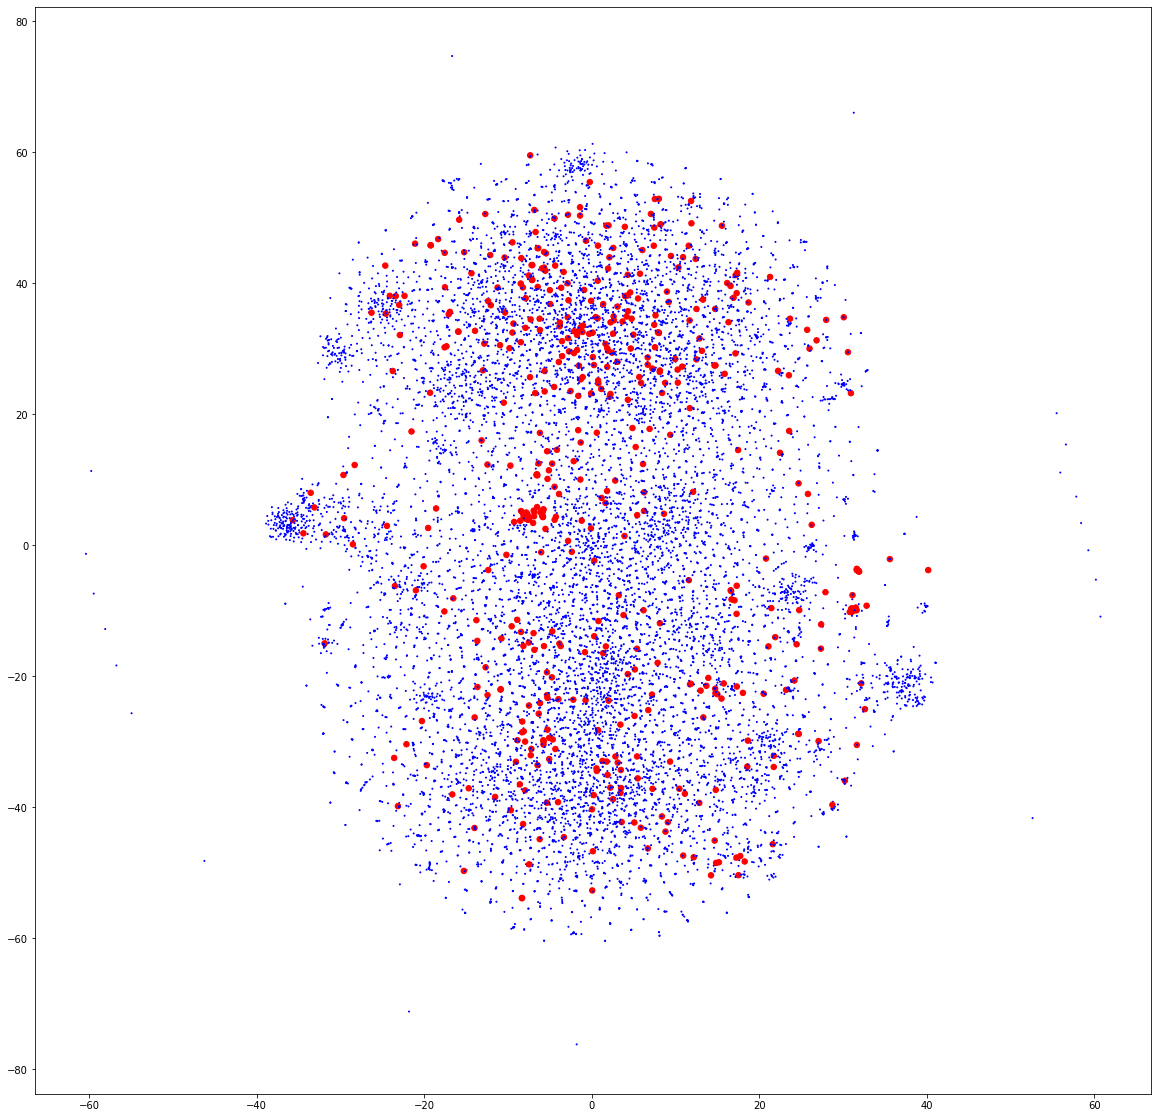

In [144]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 20))
colors = ['b'] * len(product_name_by_index)
s = [1] * len(product_name_by_index)
for i, product in product_name_by_index.items():
    if "Cream" in product:
        colors[i] = 'r'
        s[i] = 30
#     if "Cream" in product:
#         colors[i] = 'y'
plt.scatter(X2[:,0], X2[:,1], c=colors, s=s)

In [68]:
product_name_by_index

{0: 'Bombay Potatoes Vegetarian',
 1: 'Garlic Couscous',
 2: 'Peanut Chocolate Candies',
 3: 'Buffalo Wing Deli Style Pretzel Crackers',
 4: 'Vanilla Bean Chia Pod',
 5: 'Original Non-Dairy Beverage',
 6: 'Barbeque Potato Chips',
 7: 'High Fiber English Muffin',
 8: 'Organic Creamy Almond Butter',
 9: 'Baked White Cheddar Cheese Puffs',
 10: 'Cream On Top Vanilla Organic Yogurt',
 11: 'Whole Milk Greek Plain',
 12: "Mandarin Orange Crispy Chick'n",
 13: 'Blend Blueboon Coffee',
 14: 'Olive Oil & Garlic Pasta Sauce',
 15: 'Chocolate Hazelnut Butter',
 16: 'Cookies And Cream Ice Cream',
 17: 'Green Chiles, Diced, Fire Roasted, Mild',
 18: 'Squeezed Lemonade',
 19: 'Peppered Beef Jerky',
 20: 'Ghee',
 21: 'Organic Blueberries',
 22: '100% Whole Soy Organic Gluten Free Tamari Soy Sauce',
 23: 'Classic Pate Variety Pack Wet Cat Food',
 24: 'Apple Cider Vinegar',
 25: 'Organic Protein Bar Cocoa Almond',
 26: 'Extra Wide Egg Noodles',
 27: 'Herbal Tea Lemon & Ginger Caffeine Free Tea Bags',
 